In [57]:
# Import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf, pacf, adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
# Read the pickled dataset
df = pd.read_pickle("/kaggle/input/dataset-elutions/complete_df.pkl")
df.shape

(157824, 10)

In [30]:
# Aggregate statistics
agg_stats = df.describe()
agg_stats

,y1,y2,x1,x2,x3,x4,x5,x6,x7,x8
count,157824.000000,157824.000000,157824.000000,157824.000000,157824.000000,157824.000000,157824.000000,157824.000000,157824.000000,157824.000000
mean,0.263444,0.491859,0.926383,0.394721,0.429180,0.622467,0.248980,0.045137,0.662132,0.246652
std,0.333447,0.383782,0.080297,0.192875,0.189480,0.077725,0.042041,0.094512,0.069174,0.086715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000272,0.000000,0.000000,0.100328,0.049736
25%,0.008133,0.004324,0.930394,0.213695,0.250277,0.609007,0.228150,0.028404,0.645606,0.226274
50%,0.008906,0.775743,0.935799,0.402448,0.461793,0.626668,0.251670,0.035821,0.676399,0.251988
75%,0.677681,0.791204,0.938374,0.549451,0.585648,0.640240,0.266414,0.042721,0.690239,0.272233
max,1.000000,1.000000,1.000000,0.957686,0.974826,0.982159,0.406178,1.000000,0.914145,1.000000


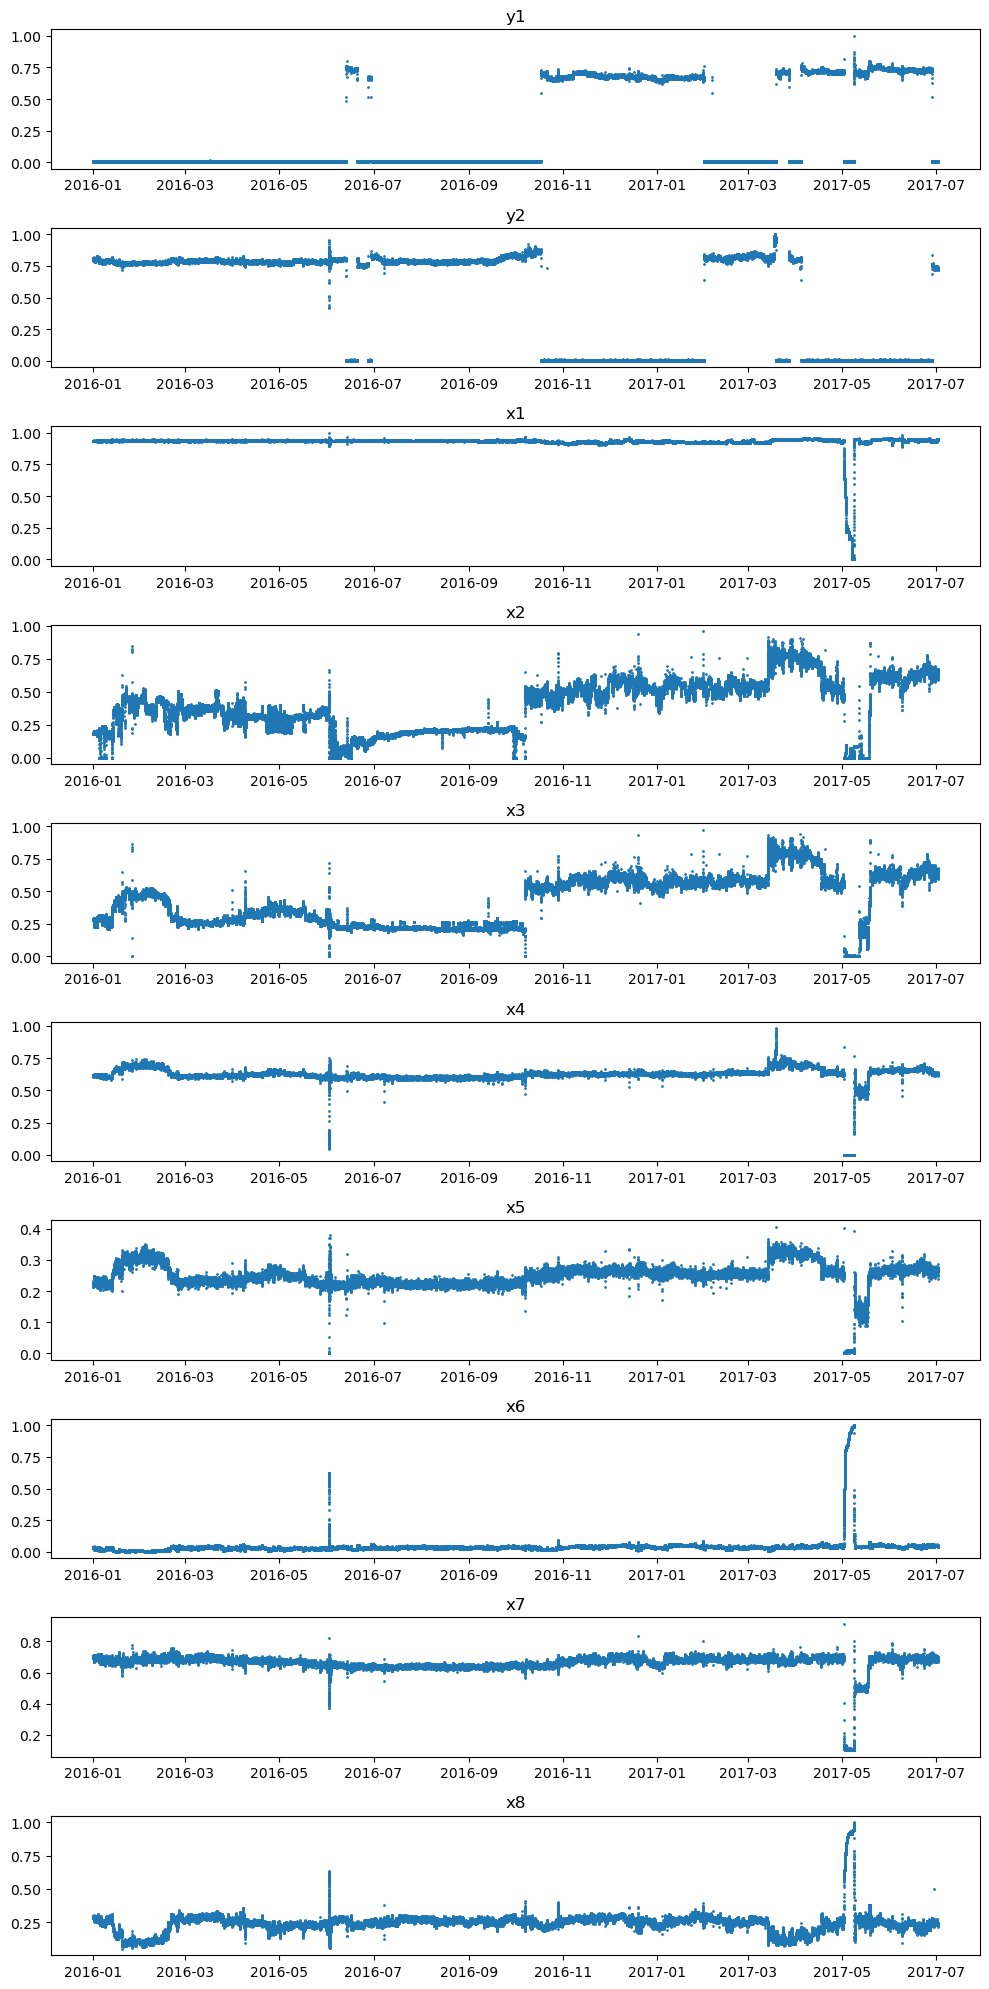

In [31]:
# Time series visualization
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 2*len(df.columns)))

for i, col in enumerate(df.columns):
    axs[i].scatter(df.index, df[col], s = 1)
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

> For dependent variables -<br>
>     1. Y1: The value remains in two different extremes. <br>
>     2. Y2: The value remains in two different extremes. And opposite to Y1. The changepoints seems same as Y1. <br>
>
> For independent variables -<br>
>     1. X1: There seems to be discernible drop in May 2017. <br>
>     2. X2: There seems to frequent fluctuations. In 2016, between June to October, the average value seems to be dropped. Again, in 2017, there seems to be a drop in May.<br>
>     3. X3: There seems to be discernible drop in June and October of 2016. In 2017 the pattern remains similar to X2.<br>
>     4. X4: There seems to be drops in June 2016 and May 2017, and a hike between March-April 2017.<br>
>     5. X5: The pattern is similar to X4. It means like there are more fluctuations as compared to X4.<br>
>     6. X6: The value remains low all the time with a hike in June 2016 and May 2017.<br>
>     7. X7: The value remains high with drops in June 2016 and May 2017.<br>
>     8. X8: The value changes between 0.0 - 0.4 with a hike in June 2016 and May 2017.<br>
>     
>    

In [60]:
# Perform the Dickey-Fuller test to determine if a time series is stationary or not
def adf_test(time_series):
    result = adfuller(df[time_series], autolag  ="AIC")
    # Extract and print the test statistic, p-value, and critical values
    print('ADF Statistic (%s): %f' % (time_series, result[0]))
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [61]:
# Perform ADF test for all the time series
for col in df.columns:
    adf_test(col)
    print('-----------------------------------')

ADF Statistic (y1): -3.654194
p-value: 0.004806
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (y2): -3.390447
p-value: 0.011289
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (x1): -6.776651
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (x2): -4.263309
p-value: 0.000514
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (x3): -2.650654
p-value: 0.082973
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (x4): -6.184449
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (x5): -5.361544
p-value: 0.000004
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
-----------------------------------
ADF Statistic (x6): -6.276984
p-va

> All the time series are stationary at 1%, 5% and 10% significance value. However, there are two exceptions: 
> 
> Y2: There is some evidence to reject the null hypothesis that the time series is non-stationary, but the evidence is not very strong. The test statistic is close to the critical value at the 1% significance level, indicating that the stationarity of the time series may be borderline at that level of significance.
> 
> X3: The results of the Dickey-Fuller test are inconclusive. The test does not provide strong evidence that the time series being tested is stationary or non-stationary. This could mean that the time series is exhibiting some trends or patterns that are not immediately apparent and require further investigation.

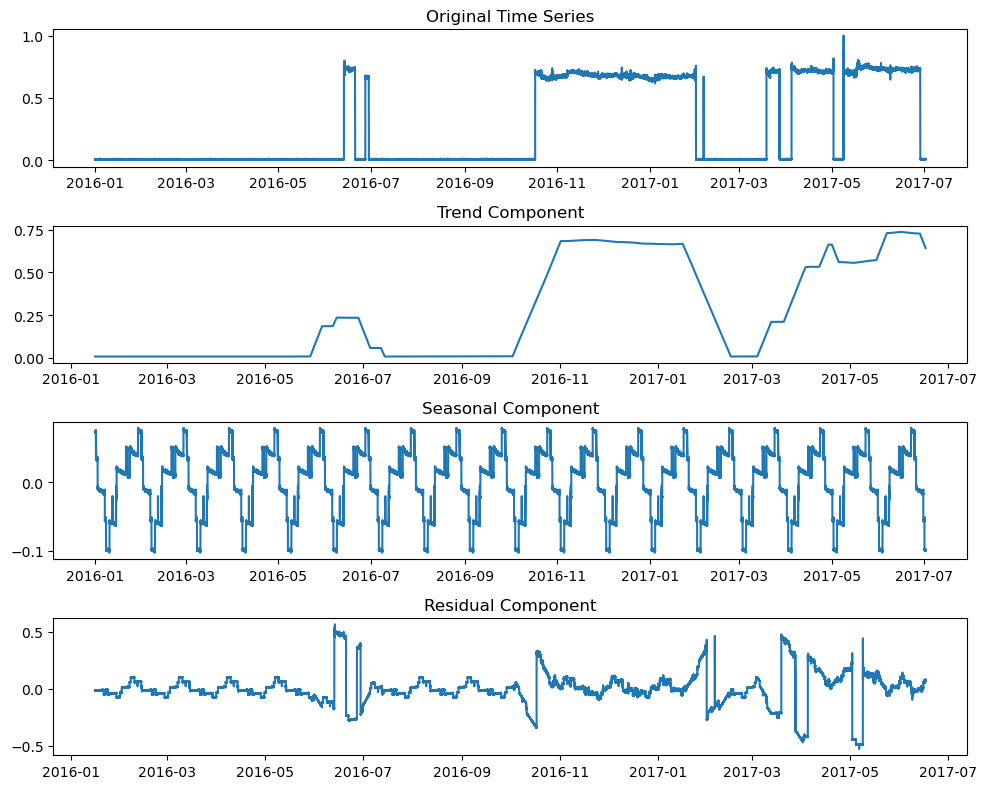

In [32]:
# Perform seasonal decomposition for 30 day time period (y1)
decomposition = seasonal_decompose(df['y1'], model='additive', period=288*30)

# Extract the trend, seasonality, and residual components
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

axs[0].plot(df['y1'])
axs[0].set_title('Original Time Series')

axs[1].plot(trend)
axs[1].set_title('Trend Component')

axs[2].plot(seasonality)
axs[2].set_title('Seasonal Component')

axs[3].plot(residual)
axs[3].set_title('Residual Component')

plt.tight_layout()
plt.show()

In [33]:
df['y1'].describe()

count    157824.000000
mean          0.263444
std           0.333447
min           0.000000
25%           0.008133
50%           0.008906
75%           0.677681
max           1.000000
Name: y1, dtype: float64

> + Mean: The average value of the time series data is 0.263, indicating that the data is positively skewed.
>
> + Standard deviation: The standard deviation of the time series data is 0.333, indicating that the data has a relatively large spread and is highly variable.
>
> + Min and Max: The minimum value of the time series data is 0 and the maximum value is 1. This indicates that the data is normalized between 0 and 1.
>
> + Quartiles: The data is divided into four equal parts, with 25% of the data below 0.008, 50% between 0.008 and 0.009, and 75% above 0.677. This indicates that the majority of the data is concentrated around the upper end of the range. <br>
>
> In summary, these statistics suggest that the time series y1 has a relatively large variability and is positively skewed with the majority of data concentrated around the upper end of the range. 

In [34]:
seasonality.describe()

count    157824.000000
mean         -0.000176
std           0.048293
min          -0.103319
25%          -0.022399
50%           0.012290
75%           0.040144
max           0.079072
Name: seasonal, dtype: float64

> + The seasonality statistics show that the mean value of the seasonality component is almost zero, which means that the average seasonal pattern is close to the overall trend. The standard deviation of the seasonality component is relatively low, indicating that there is not much variability in the seasonal pattern throughout the time series.
> 
> + The minimum and maximum values of the seasonality component are also relatively close to zero, further indicating that the seasonal pattern is not very pronounced.
> 
> + The quartile values (25%, 50%, and 75%) suggest that there may be some mild seasonal variation in the time series, but it is not particularly strong or consistent. <br>
> 
> In summary, these seasonality statistics suggest that any seasonal patterns in the time series are relatively weak and may not be a major factor in predicting or detecting anomalies.

In [35]:
trend.describe()

count    149184.000000
mean          0.262070
std           0.285841
min           0.008182
25%           0.008312
50%           0.108399
75%           0.569272
max           0.737419
Name: trend, dtype: float64

> + The mean value of the trend component is positive and relatively close to the overall mean of the time series (0.263), indicating that the overall trend of the time series is increasing.
> + The standard deviation of the trend component is relatively high (0.286), indicating that there is a significant amount of variability in the trend over time.
> + The minimum and maximum values of the trend component are also relatively close to the overall range of the time series (0 to 1), indicating that the trend component is a significant contributor to the overall variation in the time series.
> + The median value of the trend component is relatively low (0.108), indicating that there may be some periods of time where the trend is relatively flat or even decreasing.

In [36]:
residual.describe()

count    149184.000000
mean          0.000030
std           0.143365
min          -0.530301
25%          -0.045937
50%          -0.009272
75%           0.058633
max           0.565121
Name: resid, dtype: float64

> + The statistics of the residual component show that the mean is close to zero, indicating that the trend and seasonality components explain most of the variation in the data.
> + The standard deviation of the residual component is relatively large compared to the mean, indicating that there are still some unexplained variations in the data.
> + The minimum and maximum values are also relatively far from zero, suggesting that there might be some significant outliers or extreme values in the data.

In [37]:
# Calculate ACF for Y1
acf_scores = acf(df['y1'].resample("1m").mean(), nlags=18)
acf_scores

array([ 1.        ,  0.5052613 ,  0.15211394, -0.07468765,  0.06281397,
        0.34943636,  0.17111651, -0.02222141, -0.32074304, -0.35630995,
       -0.23393014, -0.17418112, -0.09513238, -0.12826198, -0.1303278 ,
       -0.1373114 , -0.07780239, -0.02719301,  0.03736021])

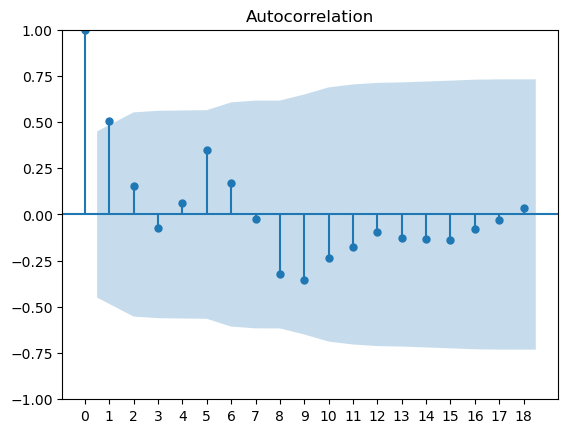

In [38]:
# Plot ACF for Y1
plot_acf(df['y1'].resample("1m").mean(), lags=18)
xticks = np.arange(0, 19, 1)
plt.xticks(xticks, xticks)
plt.show()

> + The second value is positive and significant, indicating a high correlation with the first lag. This could suggest a trend in the data. 
> + The third value is also positive but smaller than the second one, indicating a weaker correlation. However, the fourth value is negative, indicating a possible pattern of alternating signs in the data.
> + The fifth value is positive, indicating that there is still some correlation between the time series and the fifth lag. However, the magnitude of the correlation decreases, and the next few values are mostly negative and small. This suggests that the time series may not have a significant correlation with lags beyond the fifth.
> 
> Overall, these ACF values suggest that the time series may have some trend or pattern in the data, but it is not a strong or persistent one.

In [39]:
# Calculate PACF for Y1
pacf_scores = pacf(df['y1'].resample("1m").mean(), nlags=8)
pacf_scores

array([ 1.        ,  0.53333137, -0.15992094, -0.15571366,  0.33230007,
        0.49882599, -0.62744995, -0.18100552, -0.37904618])

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


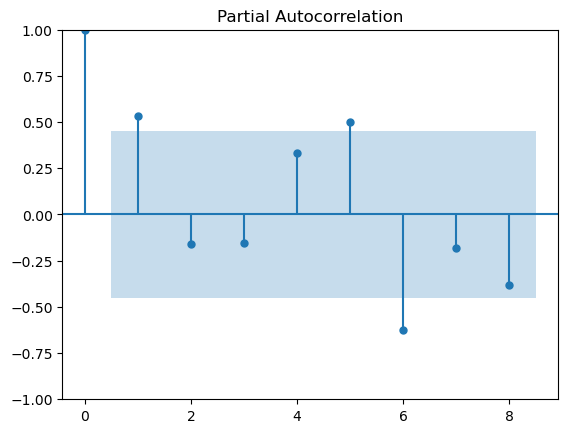

In [40]:
# Plot PACF for Y1
plot_pacf(df['y1'].resample("1m").mean(), lags=8)
plt.show()

> + The largest positive score is 0.534, which indicates a moderate positive correlation between the time series and its first lagged value.
> + The correlation at lag 4 and lag 5 also suggest that the time series has positive correlation with 5th and 6th months.
> + Overall, the scores suggest that the time series has moderately high correlation with some of its lagged values.

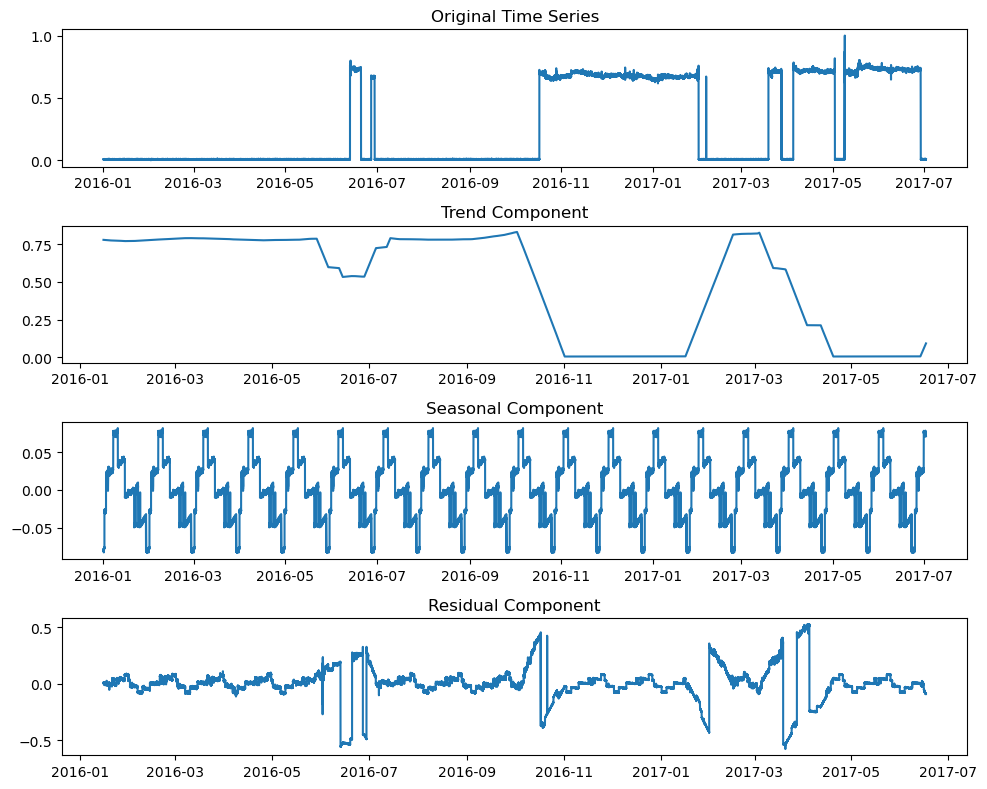

In [41]:
# Perform seasonal decomposition for 30 day time period (y2)
decomposition = seasonal_decompose(df['y2'], model='additive', period=288*30)

# Extract the trend, seasonality, and residual components
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

axs[0].plot(df['y1'])
axs[0].set_title('Original Time Series')

axs[1].plot(trend)
axs[1].set_title('Trend Component')

axs[2].plot(seasonality)
axs[2].set_title('Seasonal Component')

axs[3].plot(residual)
axs[3].set_title('Residual Component')

plt.tight_layout()
plt.show()

In [42]:
df['y2'].describe()

count    157824.000000
mean          0.491859
std           0.383782
min           0.000000
25%           0.004324
50%           0.775743
75%           0.791204
max           1.000000
Name: y2, dtype: float64

> The summary statistics suggest that the time series has a relatively high mean and large variability, with most of the observations concentrated between the first and third quartiles.

In [43]:
seasonality.describe()

count    157824.000000
mean          0.000261
std           0.042484
min          -0.083049
25%          -0.038742
50%          -0.001587
75%           0.031967
max           0.081646
Name: seasonal, dtype: float64

> The mean is close to zero and the standard deviation is relatively small, which indicates that the seasonal pattern is not very strong. The minimum and maximum values are also not too far from zero, which further supports this conclusion.

In [44]:
trend.describe()

count    149184.000000
mean          0.492718
std           0.339230
min           0.003932
25%           0.004284
50%           0.694348
75%           0.783514
max           0.833552
Name: trend, dtype: float64

> + Based on these statistics, we can see that the trend component has a mean of 0.49 and a standard deviation of 0.34. 
> + The minimum and maximum values of the trend component are relatively close to zero and one, respectively, indicating that the trend is fairly strong. 
> + The 25th and 50th percentiles are both close to zero, which suggests that the trend may be relatively flat for a significant portion of the time series. 
> + The 75th percentile is close to one, indicating that the trend may be increasing for a significant portion of the time series. 
> + In summary, the statistics suggest that there is a relatively strong trend component in this time series. 

In [45]:
residual.describe()

count    149184.000000
mean         -0.000283
std           0.149738
min          -0.577522
25%          -0.035498
50%           0.001783
75%           0.045458
max           0.525351
Name: resid, dtype: float64

> + The mean of the residual component is close to zero, indicating that, on average, the model is able to capture the trend and seasonality of the data, and the residual values are centered around zero.
> + The standard deviation of the residual component is relatively high compared to the mean value, indicating that there may be some large deviations from the fitted model.
> + The minimum and maximum values of the residual component are quite far from zero, suggesting that there may be some outliers or extreme values that are not captured by the model.

In [46]:
# Calculate ACF for Y2
acf_scores = acf(df['y2'].resample("1m").mean(), nlags=18)
acf_scores

array([ 1.        ,  0.54077856,  0.09977733, -0.11333029,  0.07788147,
        0.3578328 ,  0.19919501, -0.01094874, -0.31099328, -0.34556673,
       -0.23967881, -0.16250339, -0.1035085 , -0.12079074, -0.13439122,
       -0.14575472, -0.09032075, -0.0269748 ,  0.02929677])

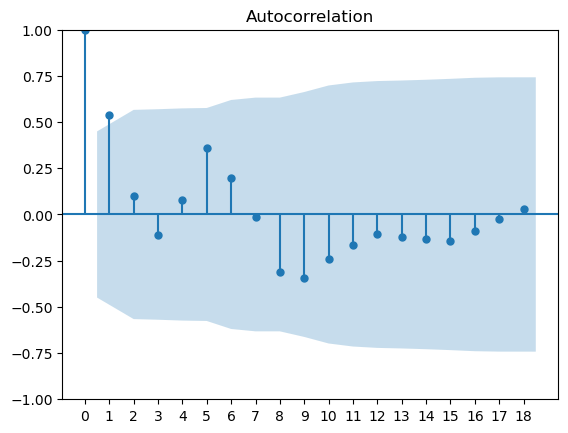

In [47]:
# Plot ACF for Y2
plot_acf(df['y2'].resample("1m").mean(), lags=18)
xticks = np.arange(0, 19, 1)
plt.xticks(xticks, xticks)
plt.show()

> + At lag 1, the ACF value is positive and relatively high (0.54), indicating a moderate positive correlation between the time series and its first lag.
> 
> + At lags 2 and 3, the ACF values are negative, indicating a negative correlation between the time series and its second and third lags.
> 
> + At lags 4-6, the ACF values are positive and relatively high, indicating a positive correlation between the time series and its fourth, fifth, and sixth lags.
> 
> + At lags 7-18, the ACF values are negative and relatively low, indicating a weak negative correlation between the time series and its past lags at these lags. 
> 
> Overall, the ACF values suggest that the time series may have some seasonality or cyclical pattern, as indicated by the positive correlations at lags 4-6. Since the values are within confidence interval, this is not significant.

In [48]:
# Calculate PACF for Y2
pacf_scores = pacf(df['y2'].resample("1m").mean(), nlags=8)
pacf_scores

array([ 1.        ,  0.57082181, -0.31790808, -0.06105854,  0.43470899,
        0.37620557, -0.64667494,  0.21447339, -0.77509326])

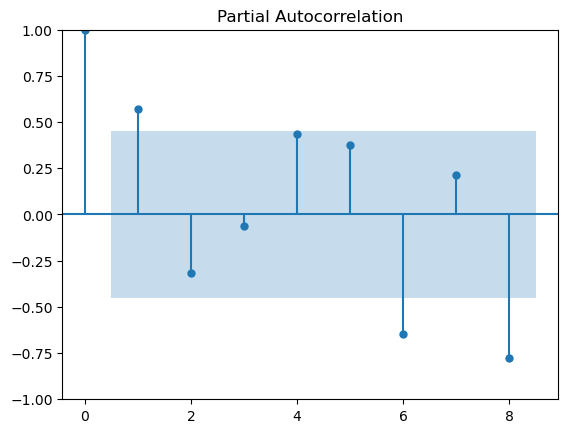

In [49]:
# Plot the PACF for Y2
plot_pacf(df['y2'].resample("1m").mean(), lags=8)
plt.show()

+ We can see that the first lag has a high correlation coefficient of 0.5708. 
+ At lag 6, the PACF value is significant. This suggests that there is a strong negative correlation between the observations at lag 6.
+ At lag 8, the PACF value is -0.77509326 which is significant. This suggests that there is a strong negative correlation between the observations at lag 8, after controlling for the effects of the intervening time steps (in months here). This can potentially indicate a seasonal pattern in the data with a period of 8 months.

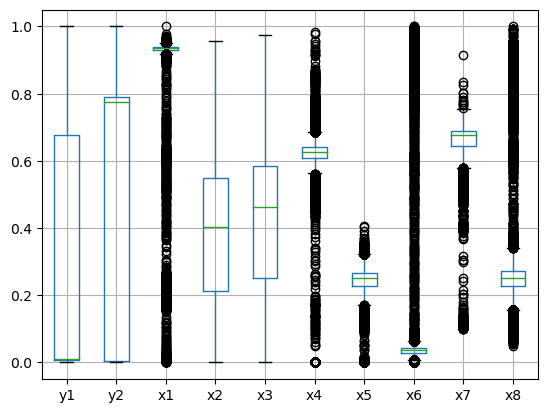

In [50]:
# Outlier detection
plt.figure()
df.boxplot()
plt.show()

In [51]:
# Threshold is 3
for i in ['x1','x2','x3','x4','x5','x6','x7','x8']:
    z_scores = np.abs((df[i] - df[i].mean()) / df[i].std())
    outliers_upper = df['x1'][z_scores > 3]
    outliers_lower = df['x1'][z_scores <- 3]
    print("Outlier(s) in {} are {}".format(i, outliers_upper.shape[0]+outliers_lower.shape[0]))

Outlier(s) in x1 are 1853
Outlier(s) in x2 are 0
Outlier(s) in x3 are 0
Outlier(s) in x4 are 2016
Outlier(s) in x5 are 2402
Outlier(s) in x6 are 1931
Outlier(s) in x7 are 1979
Outlier(s) in x8 are 1978


> + There appears to be several outliers in all the independent variables except x2 and x3. 
> + It is important to identify and handle outliers appropriately before building the forecasting model. Depending on the nature of the data, outliers can be treated in several ways such as removing them, replacing them with a more appropriate value, or transforming the data to minimize their effect. 
> + The specific method for handling outliers may vary based on the data and the specific context of the forecasting problem. However, in this scenario, I am not aware of the context. Therefore, I plan to not take any action on the outliers.  

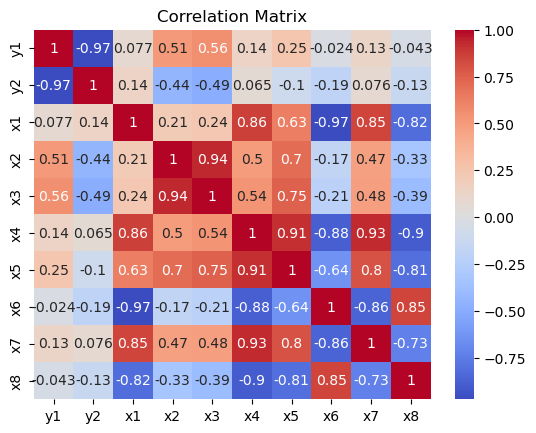

In [52]:
# Create a correlation matrix to quantify the relationships between the
# independent and dependent variables
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

> The correlation coefficient ranges between -1 and 1, with values closer to -1 indicating a strong negative correlation, values closer to 1 indicating a strong positive correlation, and values close to 0 indicating little or no correlation. A correlation coefficient of 0 indicates that there is no linear relationship between the two variables.

> Looking at the matrix, we can observe some interesting correlations. For instance, y1 and y2 are highly negatively correlated (-0.971), which indicates that as one variable increases, the other tends to decrease, x1 is significantly positively correlated with x4, x5 and x7, and significantly negatively correlated with x6 and x8 and others. 

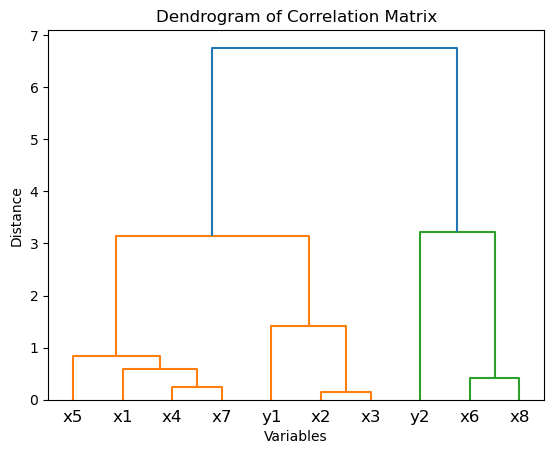

In [53]:
# Clustering can help to identify patterns and similarities between different time series (8 Independent Variables).
# Use hierarchical clustering to create a dendrogram 
linkage_matrix = hierarchy.linkage(corr.values, method='ward')
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=corr.columns)

# Show the dendrogram
plt.title('Dendrogram of Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.show()

> The dendogram reveals that:
> 1. x1, x4, x5 and x7 are similar to each other.
> 2. x2 and x3 are similar, and they are similar to y1.
> 3. x6 and x8 are similar, and they are similar to y2.